# Robust Statistical Workflow with PyStan

Stan and its implementation of dynamic Hamiltonian Monte Carlo is an extremely powerful tool for specifying and then fitting complex Bayesian models.  In order to ensure a robust analysis, however, that power must be complemented with responsibility.

In particular, while dynamic implementations of Hamiltonian Monte Carlo, i.e. implementations where the integration time is dynamic, do perform well over a large class of models their success is not guaranteed.  When they do fail, however, their failures manifest in diagnostics that are readily checked.

By acknowledging and respecting these diagnostics you can ensure that Stan is accurately fitting the Bayesian posterior and hence accurately characterizing your model.  And only with an accurate characterization of your model can you utilize its insights.

## A Little Bit About Markov Chain Monte Carlo

Hamiltonian Monte Carlo is an implementation of Markov chain Monte Carlo, which approximates expectations with respect to a given target distribution, $\pi$,
$$
\mathbb{E}_{\pi} [ f ] = \int \mathrm{d}q \, \pi (q) \, f(q),
$$
using the states of a Markov chain, $\{q_{0}, \ldots, q_{N} \}$,
$$
\mathbb{E}_{\pi} [ f ] \approx
\hat{f}_{N} = \frac{1}{N + 1} \sum_{n = 0}^{N} f(q_{n}).
$$
Typically the target distribution is taken to be the posterior distribution of our specified model.

These estimators are guaranteed to be accurate only _asymptotically_,
as the Markov chain grows to be infinitely long,
$$
\lim_{N \rightarrow \infty} \hat{f}_{N} = \mathbb{E}_{\pi} [ f ].
$$

To be useful in applied analyses, we need these Markov chain Monte Carlo estimators to converge to the true expectation values sufficiently quickly that they are reasonably accurate
_before_ we exhaust our finite computational resources.  This fast convergence
requires strong ergodicity conditions to hold, typically _geometric
ergodicity_ between the Markov transition and target distribution.  In particular, geometric
ergodicity is a sufficient condition for Markov chain Monte Carlo estimators to follow
a central limit theorem, which ensures not only that they are unbiased
after only a finite number of iterations but also that we can empirically
quantify their precision,
$$
\hat{f}_{N} - \mathbb{E}_{\pi} [ f ] \sim \mathcal{N} \! \left( 0, \sqrt{ \mathrm{Var}[f] / N_{\mathrm{eff}}} \right).
$$

Unfortunately proving geometric ergodicity theoretically is infeasible for
any nontrivial problem.  Instead we must rely on empirical diagnostics that
identify _obstructions_ to geometric ergodicity, and hence well-behaved Markov chain Monte Carlo estimators.  For a general Markov transition and target distribution, the best
known diagnostic is the split $\hat{R}$ statistic over an ensemble of Markov
chains initialized from diffuse points in parameter space.  To do any better we
need to exploit the particular structure of a given transition or target
distribution.

Hamiltonian Monte Carlo, for example, is especially powerful in this regard as
its failures to be geometrically ergodic with respect to any target distribution
manifest in distinct behaviors that have been developed into sensitive
diagnostics.  One of these behaviors is the appearance of _divergences_ that
indicate the Hamiltonian Markov chain has encountered regions of high curvature
in the target distribution which it cannot adequately explore.  Another is the _energy Bayesian fraction of missing information_, or E-BFMI, which quantifies the efficacy of the momentum resampling in between Hamiltonian trajectories.

For more details on Markov chain Monte Carlo and Hamiltonian Monte Carlo see "A Conceptual Introduction to Hamiltonian Monte Carlo" arXiv:1701.02434 (https://arxiv.org/abs/1701.02434).

In this case study I will demonstrate the recommended Stan workflow in Python where we not only fit a model but also scrutizing these diagnostics and ensure an accurate fit.


## Setting Up The PyStan Environment

We begin by importing the PyStan module as well at the matplotlib module for basic graphics facilities.

In [1]:
import pystan
import matplotlib
import matplotlib.pyplot as plot

Unfortunately diagnostics are a bit ungainly to check in PyStan 2.16.0, so to facilitate the workflow I have included a utilty module with some useful functions.

In [2]:
import stan_utility
help(stan_utility)

Help on module stan_utility:

NAME
    stan_utility

FUNCTIONS
    check_div(sampler_params)
        Check transitions and ended with a divergence
    
    check_energy(sampler_params)
        Checks the energy Bayesian fraction of missing information (E-BFMI)
    
    check_treedepth(sampler_params, max_depth=10)
        Check transitions that ended prematurely due to maximum treedepth limit
    
    compile_model(filename, model_name=None, **kwargs)
        This will automatically cache models - great if you're just running a
        script on the command line.
        
        See http://pystan.readthedocs.io/en/latest/avoiding_recompilation.html
    
    partition_div(fit)
        Returns parameter arrays separted into divergent and non-divergent transitions

FILE
    /Users/xitrium/scm/jupyter_case_studies/pystan_workflow/stan_utility.py




## Specifying and Fitting A Model in Stan

To demonstrate the recommended Stan workflow let's consider a hierarchical model of the eight schools dataset infamous in the statistical literature,

$$\mu \sim \mathcal{N}(0, 5)$$

$$\tau \sim \text{Half-Cauchy}(0, 5)$$

$$\theta_{n} \sim \mathcal{N}(\mu, \tau)$$

$$y_{n} \sim \mathcal{N}(\theta_{n}, \sigma_{n}),$$

where $n \in \left\{1, \ldots, 8 \right\}$ and the
$\left\{ y_{n}, \sigma_{n} \right\}$ are given as data. 

For more inforamation on the eight schools dataset see "Bayesian Data Analysis" by Gelman et al.

### Specifying the Model with a Stan Program

In particular, let's implement a centered-parameterization of the model which is known to frustrate even sophisticated samplers like Hamiltonian Monte Carlo.  In Stan the centered parameterization is specified with the Stan program

In [3]:
with open('eight_schools_cp.stan', 'r') as file:
    print(file.read())

data {
  int<lower=0> J;
  real y[J];
  real<lower=0> sigma[J];
}

parameters {
  real mu;
  real<lower=0> tau;
  real theta[J];
}

model {
  mu ~ normal(0, 5);
  tau ~ cauchy(0, 5);
  theta ~ normal(mu, tau);
  y ~ normal(theta, sigma);
}



Note that we have specified the Stan program in its own file.  We strongly recommend keeping your workflow modular by separating the Stan program from the Python environment in this way.  Not only does it make it easier to identify and read through the Stan-specific components of your anaylsis, it also makes it easy to share your models Stan users exploiting workflows in environments, such as R and the command line.

Given the Stan program we then use the `compile_model` method of our `stan_utility` module to compile the Stan program into a C++ executable,

In [4]:
model = stan_utility.compile_model('eight_schools_cp.stan')

Using cached StanModel


This is not technically necessary, but it allows us to cache the executable and run this model with Stan multiple times without having to recompile between each run.

### Specifying the Data

Similarly, we strongly recommend that you specify the data in its own file.  

Data specified in a Python dictionary can be immediately converted to an external Stan data file using PyStan's `stan_rdump` function,

In [5]:
data = dict(J = 8, y = [28,  8, -3,  7, -1,  1, 18, 12], 
            sigma = [15, 10, 16, 11,  9, 11, 10, 18])

pystan.stan_rdump(data, 'eight_schools.data.R')

At the same time, an existing Stan data file can be read into the Python environment using the `read_rdump` function,

In [6]:
data = pystan.read_rdump('eight_schools.data.R')

### Fitting the Model

With the model and data specified we can now turn to Stan to quantify the resulting posterior distribution with Hamiltonian Monte Carlo,

In [7]:
fit = model.sampling(data=data, seed=194838)

We recommend explicitly specifying the seed of Stan's random number generator, as we have done here, so that we can reproduce these exactly results in the future.  This is especially helpful for the more subtle pathologies that may not always be found, which results in seemingly stochastic behavior.

By default the `sampling` method runs 4 Markov chains of Hamiltonian Monte Carlo in parallel, each initialized from a diffuse initial condition to maximize the probability that at least one of the chains might encounter a pathological neighborhood of the posterior, if it exists.
Each of those chains proceeds with 1000 warmup iterations and 1000 sampling iterations, totaling 4000 sampling iterations available for diagnostics and analysis.

## Validating a Fit in Stan

We are now ready to validate the fit using the `sampler_params` contained in the `fit` object,


In [8]:
sampler_params = fit.get_sampler_params(inc_warmup=False)

### Checking Split $\hat{R}$ and Effective Sample Sizes

The first diagnostics we check are universal to Markov chain Monte Carlo and are displayed using the `print` method of the `fit` object,

In [9]:
print(fit)

Inference for Stan model: anon_model_71b609c34d59a40b345b5328a36dbb39.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu         4.28    0.14   2.97  -1.79   2.51   4.38   6.05  10.55    482   1.01
tau        3.46    0.27   2.94   0.65   1.26   2.66   4.65  11.19    117   1.06
theta[0]   5.89     0.2    5.2  -2.97   3.04   4.93   8.22  18.53    652   1.01
theta[1]   4.67    0.15   4.29  -3.76   2.23   3.96   7.03  14.08    780    1.0
theta[2]   3.83    0.16   4.75  -6.22   1.31   4.21   6.38  12.71    909    1.0
theta[3]   4.66    0.15   4.38  -4.14   2.38   4.74   7.01  14.33    892    1.0
theta[4]   3.61    0.16   4.38  -6.53   1.37   3.88   5.91  11.83    742   1.01
theta[5]   3.86    0.16   4.54  -6.14   1.62   3.93   6.33  12.83    846    1.0
theta[6]   5.96    0.22   4.75  -1.96   2.91   4.84   8.35  17.36    461   1.01
theta[7]   

Firstly we want to ensure that the split $\hat{R}$ for each parameter is close to 1.  Empirically we have found that `Rhat > 1.1` is usually indicative of problems in the fit.  Here all of the parameters look good except for the log posterior density, `lp__`, which should inspire some small hesitation in our fit.

Then we want to consider the effective sample size, or `n_eff`.  The issue here is related to the fact that we are _estimating_ the effective sample size from the fit output.  When `n_eff / n_transitions < 0.001` the estimators that we use are often biased and can significantly overestimate the true effective sample size.

Both large split $\hat{R}$ and low effective samples per transition are consequences of poorly mixing Markov chains.  Improving the mixing of the Markov chains almost always requires tweaking the model specification, for example with a reparameterization or stronger priors.


### Checking the Treedepth

The dynamic implementation of Hamiltonian Monte Carlo used in Stan has a maximum trajectory length built in to avoid infinite loops that can occur for non-identified models.  For sufficiently complex models, however, Stan can saturate this threshold even if the model is identified, which limits the efficacy of the sampler.  

We can check whether that threshold was hit using one of our utility functions,

In [10]:
stan_utility.check_treedepth(sampler_params)

0 of 4000 iterations saturated the maximum tree depth of 10(0.0%)


We're good here, but if our fit had saturated the threshold then we would have wanted to rerun with a larger maximum threedepth,

In [11]:
# fit = model.sampling(data=data, seed=194838, control=dict(max_treedepth=15))

and then check if still saturated this larger threshold with

In [12]:
# stan_utility.check_treedepth(sampler_params, 15)

### Checking the E-BFMI

Hamiltonian Monte Carlo proceeds in two phases -- the algorithm first simulates a Hamiltonian trajectory that rapidly explores a slice of the target parameter space before resampling the auxiliary momenta to allow the next trajectory to explore another slice of the target parameter space.  Unfortunately, the jumps between these slices induced by the momenta resamplings can be short, which often leads to slow exploration.  

We can identify this problem by consulting the energy Bayesian Fraction of Missing Information,

In [13]:
stan_utility.check_energy(sampler_params)

Chain 2: E-BFMI = 0.1776813469508347
E-BFMI below 0.2 indicates you may need to reparameterize your model


The `stan_utility` module uses the threshold of 0.2 to diagnose problems, although this is based on preliminary empirical studies and should be taken only as a very rough recommendation.  In particular, this diagnostic comes out of recent theoretical work and will be better understood as we apply it to more and more problems.

As with split $\hat{R}$ and effective sample size per transition, the problems indicated by low E-BFMI are remedied by tweaking the specification of the model.  Unfortunately the exact tweaks required depend on the exact structure of the model and, consequently, there are not generic solutions.

### Checking Divergences

Finally, we can check divergences which indicate pathological neighborhoods of the posterior that the simulted Hamiltonian trajectories are not able to explore sufficiently well.  For this fit we have a significant number of divergences

In [14]:
stan_utility.check_div(sampler_params)

202.0 of 4000 iterations ended with a divergence(5.05%)
Try running with larger adapt_delta to remove the divergences


indicating that the Markov chains did not completely explore the posterior and that our Markov chain Monte Carlo estimators will be biased.

Divergences, however, can sometimes be false positives.  To verify that we have fitting issues we can rerun with a larger target acceptance probability, `adapt_delta`, which will force more accurate simulations of Hamiltonian trajectories and reduce the false positives.

In [15]:
fit = model.sampling(data=data, seed=194838, control=dict(adapt_delta=0.9))

Checking again,

In [16]:
sampler_params = fit.get_sampler_params(inc_warmup=False)
stan_utility.check_div(sampler_params)

45.0 of 4000 iterations ended with a divergence(1.125%)
Try running with larger adapt_delta to remove the divergences


we see that while the divergences were reduced they did not completely vanish.  In order to argue that divergences are only false positives, the divergences have to be completely eliminated for some `adapt_delta` sufficiently close to 1.  Here we could continue increasing `adapt_delta` (where we would see that the divergences do not completely vanish), or we can analyze the existing divergences graphically.

If the divergences are not false positives then they will tend to concentrate in the pathological neighborhoods of the posterior.  Falsely positive divergent iterations, however, will be distributed the same as non-divergent iterations.

Here we will use the `partition_div` function of the `stan_utility` module to separate divergence and non-divergent iterations, but note that this function works only if your model parameters are reals, vectors, or arrays of reals.  More robust functionality is planned for future releases of PyStan.

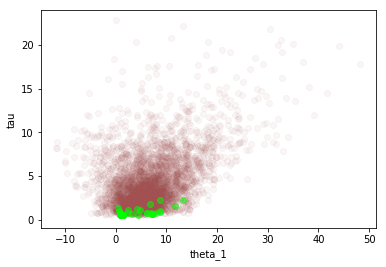

In [17]:
light="#DCBCBC"
light_highlight="#C79999"
mid="#B97C7C"
mid_highlight="#A25050"
dark="#8F2727"
dark_highlight="#7C0000"
green="#00FF00"

nondiv_params, div_params = stan_utility.partition_div(fit)

plot.scatter([x[0] for x in nondiv_params['theta']], nondiv_params['tau'], \
             color = mid_highlight, alpha=0.05)
plot.scatter([x[0] for x in div_params['theta']], div_params['tau'], \
             color = green, alpha=0.5)

plot.gca().set_xlabel("theta_1")
plot.gca().set_ylabel("tau")

plot.show()

One of the challenges with a visual analysis of divergences is determining exactly which parameters to examine.  Consequently visual analyses are most useful when there are already components of the model about which you are suspicious, as in this case where we know that the correlation between random effects (`theta_1` through `theta_8`) and the hierarchical standard deviation, `tau`, can be problematic.

Indeed we see the divergences clustering towards small values of tau where the posterior abruptly stops.  This abrupt stop is indicative of a transition into a pathological neighborhood that Stan was not able to penetrate.

In order to avoid this issue we have to consider a modification to our model, and in this case we can appeal to a _non-centered parameterization_ of the same model that does not suffer these issues.

## A Successful Fit

Multiple diagostics have indicated that our fit of the centered parameterization of our hierarchical model is not to be trusted, so let's instead consider the complementary non-centered parameterization,

In [18]:
with open('eight_schools_ncp.stan', 'r') as file:
    print(file.read())

data {
  int<lower=0> J;
  real y[J];
  real<lower=0> sigma[J];
}

parameters {
  real mu;
  real<lower=0> tau;
  real theta_tilde[J];
}

transformed parameters {
  real theta[J];
  for (j in 1:J)
    theta[j] = mu + tau * theta_tilde[j];
}

model {
  mu ~ normal(0, 5);
  tau ~ cauchy(0, 5);
  theta_tilde ~ normal(0, 1);
  y ~ normal(theta, sigma);
}



In [19]:
model = stan_utility.compile_model('eight_schools_ncp.stan')
fit = model.sampling(data=data, seed=194838)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_b4ca739f9fe7ffcdbf0d530f00d0a587 NOW.


In [20]:
print(fit)

sampler_params = fit.get_sampler_params(inc_warmup=False)
stan_utility.check_treedepth(sampler_params)
stan_utility.check_energy(sampler_params)
stan_utility.check_div(sampler_params)

Inference for Stan model: anon_model_b4ca739f9fe7ffcdbf0d530f00d0a587.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                 mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu               4.37    0.05   3.39  -2.49    2.1   4.51   6.69  10.94   4000    1.0
tau              3.59    0.06   3.19   0.13   1.27   2.79   4.95  11.68   2761    1.0
theta_tilde[0]   0.31    0.02   0.96  -1.61  -0.34   0.32   0.95   2.16   4000    1.0
theta_tilde[1]    0.1    0.01   0.92  -1.72  -0.51   0.12   0.72    1.9   3766    1.0
theta_tilde[2]  -0.08    0.02   0.98   -2.0  -0.74  -0.08   0.55   1.91   4000    1.0
theta_tilde[3]   0.05    0.01   0.94  -1.86  -0.57   0.07   0.68   1.87   4000    1.0
theta_tilde[4]  -0.16    0.02   0.95  -2.03  -0.79  -0.17   0.47   1.71   3681    1.0
theta_tilde[5]  -0.09    0.01   0.92  -1.95  -0.71   -0.1   0.52   1.76   3787    1.0
theta_tilde[6]   0.37    0.02   0.97 

With this more appropriate implementation of our model all of the diagnostics are clean and we can now utilize Markov chain Monte Carlo estimators of expecations, such as parameter means and variances, to accurately characterize our model's posterior distribution.

## Acknowledgements

I thank Sean Talts for helping to make the functions in `stan_utility` more Pythonic and compatible with both Python 2 and Python 3, and Sean Talts and Maggie Lieu for helpful comments on the notebook.